## Replication: When to use and when not to use BBR: An empirical analysis and evaluation study

This experiment replicates Figure 5 of

> Yi Cao, Arpit Jain, Kriti Sharma, Aruna Balasubramanian, and Anshul Gandhi. 2019. When to use and when not to use BBR: An empirical analysis and evaluation study. In Proceedings of the Internet Measurement Conference (IMC ’19). Association for Computing Machinery, New York, NY, USA, 130–136. https://doi.org/10.1145/3355369.3355579

and also extends it to a more recent version of BBRv1 and to BBRv2.

To run this experiment:

-   **Prerequisites**: You should have a FABRIC account, be part of a FABRIC project, and have configured your FABRIC Jupyter environment, as in [“Hello, FABRIC”](https://teaching-on-testbeds.github.io/blog/hello-fabric). Then, `git clone` this repository in the FABRIC JupyterHub environment, navigate to the “fabric-notebooks” directory, and open the “fabric-run.ipynb” file.
-   **Configuration**: Next, you need to edit some parts of this notebook, depending on the version of the experiment you want to run.
    -   In the “Define configuration for this experiment” section, set the `slice_name` prefix - slice names must be unique, so if you are running multiple slices in parallel (for example, to validate the result for the three BBR versions in parallel slices), make each have a unique name.
    -   In the “Define configuration for this experiment” section, set the `image` variable - “default_ubuntu_18” to validate the result in the original paper (4.15 kernel), “default_ubuntu_22” for a newer BBRv1 (5.15 kernel), or “default_ubuntu_20” for BBRv2 (will use 5.13 kernel).
    -   If you are evaluating BBRv2, in the “Extra configuration for this experiment” section set `is_bbr2` to `True`. (Otherwise, leave it as `False`.)
    -   If you are evaluating BBRv2, in the “Execute experiment” section set the `cc` in the `exp_factors` dictionary to `["cubic", "bbr2"]`. (Otherwise, leave it at `["cubic", "bbr"]`.)
    -   If you are running multiple versions of this notebook in parallel, it’s easiest to duplicate the notebook (right-click on the file in the JupyterHub file browser, choose Duplicate), configure the copy as described above, and execute the copy.
-   **Execution**: Once you are ready, you’ll want to run all of the cells in this notebook in order. An easy way to do this is to scroll to the “Delete your slice” section at the end, click on the cell that has the title of this section, and choose Run \> Run All Above Selected Cell from the JupyterHub menu to run all cells until this point.
    -   In case there is a problem reserving resources (i.e. an infrastructure problem), you will want to delete your slice and try again. To do this, you would run the cells in the “Delete your slice” section, make sure your slice is deleted, then run the cells above that section again (using Run \> Run All Above Selected Cell for convenience).
    -   This full-factorial experiment design takes many hours to run. Once you have confirmed that the main loop in the “Execute experiment” section is running, you can leave this notebook running unattended.
    -   Every 24 hours or less, your FABRIC JupyterHub session will time out, and you’ll need to resume execution. When you get the alert that your server has stopped, you should: (1) Force restart your JupyterHub server: File \> Hub Control Panel \> Stop My Server, then Start Server. (2) Re-run the first few code cells, until you see the output “You already have a slice by this name!”. (3) Scroll to the “Execute experiment” section and continue running cells in order from this point on.

### Configure environment

In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,nm3833_0000195331
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


### Define configuration for this experiment

In [7]:
slice_name="re-when-to-use-bbr-" + fablib.get_bastion_username()

# use default_ubuntu_22 for 5.15 kernel, default_ubuntu_18 for 4.15 kernel, default_ubuntu_20 for BBRv2
image = 'default_ubuntu_22' 

node_conf = [
 {'name': "h1",  'cores': 4, 'ram': 16, 'disk': 500, 'image': image, 'packages': ['iperf3']}, 
 {'name': "h2",  'cores': 4, 'ram': 16, 'disk': 10, 'image': image, 'packages': ['iperf3']}, 
 {'name': "h3",  'cores': 4, 'ram': 16, 'disk': 10, 'image': image, 'packages': ['iperf3']}, 
 {'name': "tbf", 'cores': 8, 'ram': 32, 'disk': 10, 'image': image, 'packages': []} 
]
net_conf = [
 {"name": "link1", "subnet": "10.10.1.0/24", "nodes": [{"name": "tbf",   "addr": "10.10.1.10"}, {"name": "h1", "addr": "10.10.1.1"}]},
 {"name": "link2", "subnet": "10.10.2.0/24", "nodes": [{"name": "tbf",   "addr": "10.10.2.10"}, {"name": "h2", "addr": "10.10.2.1"}]},
 {"name": "link3", "subnet": "10.10.3.0/24", "nodes": [{"name": "tbf",   "addr": "10.10.3.10"}, {"name": "h3", "addr": "10.10.3.1"}]}
]
route_conf = [
 {"addr": "10.10.3.0/24", "gw": "10.10.1.10", "nodes": ["h1"]}, 
 {"addr": "10.10.3.0/24", "gw": "10.10.2.10", "nodes": ["h2"]},  
 {"addr": "10.10.1.0/24", "gw": "10.10.3.10", "nodes": ["h3"]},  
 {"addr": "10.10.2.0/24", "gw": "10.10.3.10", "nodes": ["h3"]}
]
exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }

### Reserve resources

Now, we are ready to reserve resources!

First, make sure you don’t already have a slice with this name:

In [8]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named re-when-to-use-bbr-nm3833_0000195331 yet.
Continue to the next step to make one.


We will select a random site that has sufficient resources for our experiment:

In [9]:
# while True:
#     site_name = fablib.get_random_site()
#     if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
#         (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
#         break
site_name = 'EDUKY'
fablib.show_site(site_name)

Name,EDUKY
State,Active
Address,"301 Hilltop Avenue,Lexington, KY 40506"
Location,"(0, 0)"
PTP Capable,True
Hosts,18
CPUs,36
Cores Available,73478
Cores Capacity,73728
Cores Allocated,250
RAM Available,7928


'<pandas.io.formats.style.Styler object at 0x7db5d5adfa90>'

Then we will add hosts and network segments:

In [10]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [11]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

-   While it is being prepared, the “State” of the slice will appear as “Configuring”.
-   When it is ready, the “State” of the slice will change to “StableOK”.

You may prefer to walk away and come back in a few minutes (for simple slices) or a few tens of minutes (for more complicated slices with many resources).

In [12]:
slice.submit()


Retry: 13, Time: 390 sec


ID,ef3283d7-6584-4eab-a306-0f44ce444055
Name,re-when-to-use-bbr-nm3833_0000195331
Lease Expiration (UTC),2024-07-09 17:02:08 +0000
Lease Start (UTC),2024-07-08 17:02:10 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
532995b5-c67c-41ec-9273-f6197ea72773,h1,4,16,500,default_ubuntu_22,qcow2,eduky-w18.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe57:9396,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe57:9396,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
dbebf6b0-b549-48f0-9b53-89acfdf8650e,h2,4,16,10,default_ubuntu_22,qcow2,eduky-w12.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fea3:c1a1,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fea3:c1a1,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
7cd4b7ac-ca3e-45b3-b8a4-3f9c436f81d6,h3,4,16,10,default_ubuntu_22,qcow2,eduky-w10.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe4f:3515,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe4f:3515,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
005a02f5-9fb3-4139-afab-132870ad5e3b,tbf,8,32,10,default_ubuntu_22,qcow2,eduky-w13.fabric-testbed.net,EDUKY,ubuntu,2610:1e0:1700:206:f816:3eff:fe5d:75ab,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe5d:75ab,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
56be981a-72bc-4d09-8e03-11bcbd5dce7a,link1,L2,L2Bridge,EDUKY,None,None,Active,
e88b51d9-ce00-4764-8095-6753b7948a0b,link2,L2,L2Bridge,EDUKY,None,None,Active,
5be36bc6-95bb-4517-8ef9-39b72f81a84a,link3,L2,L2Bridge,EDUKY,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
h1-link1-p1,p1,h1,link1,100,config,,02:80:D2:D1:BA:36,enp7s0,enp7s0,None,1
h2-link2-p1,p1,h2,link2,100,config,,1A:23:AB:85:BF:51,enp7s0,enp7s0,None,1
h3-link3-p1,p1,h3,link3,100,config,,16:54:62:1B:5C:C0,enp7s0,enp7s0,None,1
tbf-link2-p1,p1,tbf,link2,100,config,,16:BF:14:E8:86:50,enp7s0,enp7s0,None,1
tbf-link3-p1,p1,tbf,link3,100,config,,1A:67:18:38:3A:59,enp9s0,enp9s0,None,1
tbf-link1-p1,p1,tbf,link1,100,config,,16:F4:DE:B2:6F:13,enp8s0,enp8s0,None,1



Time to print interfaces 398 seconds


'ef3283d7-6584-4eab-a306-0f44ce444055'

In [13]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

### Extend slice for one week

In [14]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)

In [15]:
slice.update()
_ = slice.show()

ID,ef3283d7-6584-4eab-a306-0f44ce444055
Name,re-when-to-use-bbr-nm3833_0000195331
Lease Expiration (UTC),2024-07-15 17:08:53 +0000
Lease Start (UTC),2024-07-08 17:02:10 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK


### Extra configuration for this experiment

In [16]:
# if you need to install BBR2 kernel, make this True
is_bbr2 = False
pkg_list = ['linux-headers-5.13.12_5.13.12-2_amd64.deb',
            'linux-libc-dev_5.13.12-2_amd64.deb',
            'linux-image-5.13.12_5.13.12-2_amd64.deb']
if is_bbr2:
    for node in slice.get_nodes():
        for pkg in pkg_list:
            node.upload_file("../setup/" + pkg, "/home/ubuntu/" + pkg)
        node.execute("sudo dpkg -i " + " ".join(pkg_list) + "; sudo reboot")

        # if compiling from scratch.... which takes forever...
        # node.execute("sudo apt update; sudo apt -y install libelf-dev libssl-dev libncurses-dev flex bison pkg-config gcc binutils ca-certificates build-essential")
        # node.execute("git clone -o google-bbr -b v2alpha  https://github.com/google/bbr.git")
        # node.upload_file("../setup/.config", "/home/ubuntu/bbr/.config")
        # node.execute("cd bbr; sudo make -j $(nproc) ")
        # node.execute("cd bbr; sudo make modules -j $(nproc) ")
        # node.execute("cd bbr; sudo make modules_install -j $(nproc) ")
        # node.execute("cd bbr; sudo make install -j $(nproc) ")

    # wait for all nodes to come back up
    slice.wait_ssh(progress=True)
    for node in slice.get_nodes():
        node.execute("hostname; uname -a")

In [17]:
# set socket read and write buffer on all endpoints to larger value
for node in slice.get_nodes():
    node.execute("sudo sysctl -w net.core.rmem_default=2147483647")
    node.execute("sudo sysctl -w net.core.wmem_default=2147483647")
    node.execute("sudo sysctl -w net.core.rmem_max=2147483647")
    node.execute("sudo sysctl -w net.core.wmem_max=2147483647")

net.core.rmem_default = 2147483647
net.core.wmem_default = 2147483647
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647
net.core.rmem_default = 2147483647
net.core.wmem_default = 2147483647
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647
net.core.rmem_default = 2147483647
net.core.wmem_default = 2147483647
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647
net.core.rmem_default = 2147483647
net.core.wmem_default = 2147483647
net.core.rmem_max = 2147483647
net.core.wmem_max = 2147483647


### Configure resources

Next, we will configure the resources so they are ready to use.

In [18]:
slice = fablib.get_slice(name=slice_name)

In [19]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [20]:
#turn off segmentation offload on interfaces
for iface in slice.get_interfaces():
    iface_name = iface.get_device_name()
    n = iface.get_node()
    offloads = ['gro', 'lro', 'gso', 'tso']
    for offload in offloads:
        n.execute("sudo ethtool -K %s %s off" % (iface_name, offload))

In [21]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [22]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.10.1.10 tbf
10.10.1.1 h1
10.10.2.10 tbf
10.10.2.1 h2
10.10.3.10 tbf
10.10.3.1 h3
10.10.1.10 tbf
10.10.1.1 h1
10.10.2.10 tbf
10.10.2.1 h2
10.10.3.10 tbf
10.10.3.1 h3
10.10.1.10 tbf
10.10.1.1 h1
10.10.2.10 tbf
10.10.2.1 h2
10.10.3.10 tbf
10.10.3.1 h3
10.10.1.10 tbf
10.10.1.1 h1
10.10.2.10 tbf
10.10.2.1 h2
10.10.3.10 tbf
10.10.3.1 h3


In [23]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [24]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

### Validate base network

Before we run any experiment, we should check the “base” network - before adding any emulated delay or rate limiting - and make sure that it will not be a limiting factor in the experiment.

In [25]:
# check base delay
slice.get_node("h1").execute("ping -c 5 h3")

PING h3 (10.10.3.1) 56(84) bytes of data.
64 bytes from h3 (10.10.3.1): icmp_seq=1 ttl=63 time=0.766 ms
64 bytes from h3 (10.10.3.1): icmp_seq=2 ttl=63 time=0.200 ms
64 bytes from h3 (10.10.3.1): icmp_seq=3 ttl=63 time=0.196 ms
64 bytes from h3 (10.10.3.1): icmp_seq=4 ttl=63 time=0.195 ms
64 bytes from h3 (10.10.3.1): icmp_seq=5 ttl=63 time=0.199 ms

--- h3 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4082ms
rtt min/avg/max/mdev = 0.195/0.311/0.766/0.227 ms


('PING h3 (10.10.3.1) 56(84) bytes of data.\n64 bytes from h3 (10.10.3.1): icmp_seq=1 ttl=63 time=0.766 ms\n64 bytes from h3 (10.10.3.1): icmp_seq=2 ttl=63 time=0.200 ms\n64 bytes from h3 (10.10.3.1): icmp_seq=3 ttl=63 time=0.196 ms\n64 bytes from h3 (10.10.3.1): icmp_seq=4 ttl=63 time=0.195 ms\n64 bytes from h3 (10.10.3.1): icmp_seq=5 ttl=63 time=0.199 ms\n\n--- h3 ping statistics ---\n5 packets transmitted, 5 received, 0% packet loss, time 4082ms\nrtt min/avg/max/mdev = 0.195/0.311/0.766/0.227 ms\n',
 '')

In [26]:
# check base capacity (by sending 10 parallel flows, look at their sum throughput)
import time
slice.get_node("h3").execute("iperf3 -s -1 -D")
time.sleep(5)
slice.get_node("h1").execute("iperf3 -t 30 -i 10 -P 10 -c h3")

Connecting to host h3, port 5201
[  5] local 10.10.1.1 port 40318 connected to 10.10.3.1 port 5201
[  7] local 10.10.1.1 port 40330 connected to 10.10.3.1 port 5201
[  9] local 10.10.1.1 port 40342 connected to 10.10.3.1 port 5201
[ 11] local 10.10.1.1 port 40350 connected to 10.10.3.1 port 5201
[ 13] local 10.10.1.1 port 40358 connected to 10.10.3.1 port 5201
[ 15] local 10.10.1.1 port 40364 connected to 10.10.3.1 port 5201
[ 17] local 10.10.1.1 port 40374 connected to 10.10.3.1 port 5201
[ 19] local 10.10.1.1 port 40376 connected to 10.10.3.1 port 5201
[ 21] local 10.10.1.1 port 40390 connected to 10.10.3.1 port 5201
[ 23] local 10.10.1.1 port 40404 connected to 10.10.3.1 port 5201
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-10.00  sec  1.59 GBytes  1.37 Gbits/sec  288    428 KBytes       
[  7]   0.00-10.00  sec  1.62 GBytes  1.39 Gbits/sec    0    447 KBytes       
[  9]   0.00-10.00  sec  1.62 GBytes  1.39 Gbits/sec    0    488 KBytes       
[ 11]

('Connecting to host h3, port 5201\n[  5] local 10.10.1.1 port 40318 connected to 10.10.3.1 port 5201\n[  7] local 10.10.1.1 port 40330 connected to 10.10.3.1 port 5201\n[  9] local 10.10.1.1 port 40342 connected to 10.10.3.1 port 5201\n[ 11] local 10.10.1.1 port 40350 connected to 10.10.3.1 port 5201\n[ 13] local 10.10.1.1 port 40358 connected to 10.10.3.1 port 5201\n[ 15] local 10.10.1.1 port 40364 connected to 10.10.3.1 port 5201\n[ 17] local 10.10.1.1 port 40374 connected to 10.10.3.1 port 5201\n[ 19] local 10.10.1.1 port 40376 connected to 10.10.3.1 port 5201\n[ 21] local 10.10.1.1 port 40390 connected to 10.10.3.1 port 5201\n[ 23] local 10.10.1.1 port 40404 connected to 10.10.3.1 port 5201\n[ ID] Interval           Transfer     Bitrate         Retr  Cwnd\n[  5]   0.00-10.00  sec  1.59 GBytes  1.37 Gbits/sec  288    428 KBytes       \n[  7]   0.00-10.00  sec  1.62 GBytes  1.39 Gbits/sec    0    447 KBytes       \n[  9]   0.00-10.00  sec  1.62 GBytes  1.39 Gbits/sec    0    488 KBy

In [27]:
# also check Linux kernel version on sender
slice.get_node("h1").execute("uname -a")

Linux h1 5.15.0-91-generic #101-Ubuntu SMP Tue Nov 14 13:30:08 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


('Linux h1 5.15.0-91-generic #101-Ubuntu SMP Tue Nov 14 13:30:08 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux\n',
 '')

### Draw the network topology

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [28]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

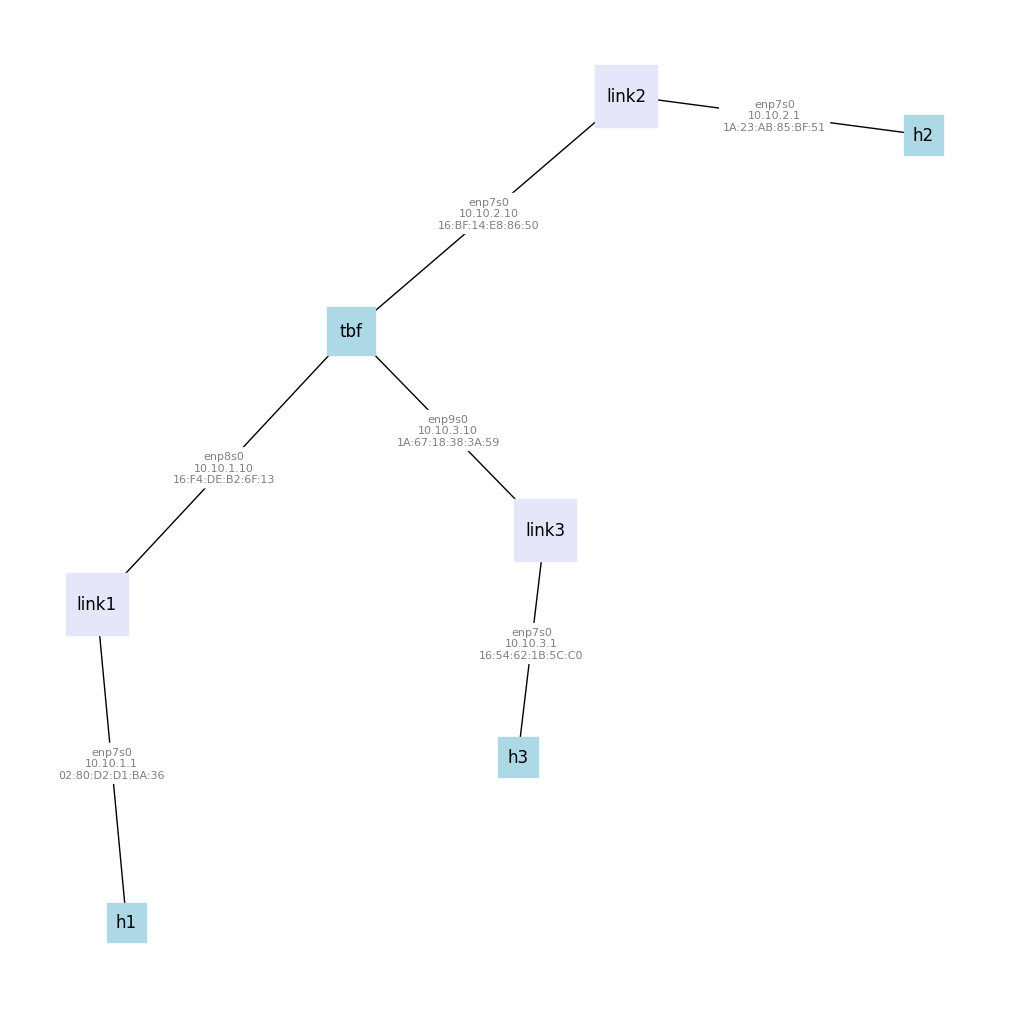

In [29]:
import networkx as nx
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G, k=1)  # Adjust the 'k' value to space out the nodes

nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True)

nx.draw_networkx_edge_labels(G, pos,
                             edge_labels=nx.get_edge_attributes(G, 'label'),
                             font_color='gray', font_size=8, rotate=False)

plt.show()


### Log into resources

Now, we are finally ready to log in to our resources over SSH! Run the following cells, and observe the table output - you will see an SSH command for each of the resources in your topology.

In [30]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
h1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe57:9396
h2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fea3:c1a1
h3,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe4f:3515
tbf,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:1e0:1700:206:f816:3eff:fe5d:75ab


Now, you can open an SSH session on any of the resources as follows:

-   in Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   copy an SSH command from the table, and paste it into the terminal. (Note that each SSH command is a single line, even if the display wraps the text to a second line! When you copy and paste it, paste it all together.)

You can repeat this process (open several terminals) to start a session on each resource. Each terminal session will have a tab in the Jupyter environment, so that you can easily switch between them.

### Execute experiment

In [31]:
# generate full factorial experiment
import itertools
exp_factors = { 
    'bufcap': [100, 10000],
    'bandwidth': [10, 20, 50, 100, 250, 500, 750, 1000],
    'rtt': [5, 10, 25, 50, 75, 100, 150, 200],
    'cc': ["cubic", "bbr"],
    'trial': [1,2,3,4,5]
}
factor_names = [k for k in exp_factors]
factor_lists = list(itertools.product(*exp_factors.values()))
exp_lists = [dict(zip(factor_names, factor_l)) for factor_l in factor_lists]

In [11]:
# get name of router interface that is 'toward' h1 - apply delay here
# get name of router interface that is 'toward' h3 - apply rate limiting and buffer size limit here
router_node = slice.get_node(name='tbf')
router_ingress_iface = router_node.get_interface(network_name = "link1")
router_ingress_name = router_ingress_iface.get_device_name()
router_egress_iface  = router_node.get_interface(network_name = "link3")
router_egress_name = router_egress_iface.get_device_name()

In [12]:
tx_node = slice.get_node(name="h1")
rx_node = slice.get_node(name="h3")

In [13]:
kernel = tx_node.execute("uname -r")[0].strip()
data_dir = kernel + "_" + exp_factors['cc'][0] + "_" + exp_factors['cc'][1]
tx_node.execute("mkdir -p " + data_dir)

5.15.0-91-generic


('', '')

In [ ]:
import time # to allow resume
for exp in exp_lists:

    # check if we already ran this experiment
    # (allow stop/resume)
    file_out = data_dir + "/%d_%d_%d_%d_%s.txt" % (exp['bufcap'], exp['bandwidth'], exp['rtt'], exp['trial'], exp['cc'])
    stdout, stderr = tx_node.execute("ls " + file_out, quiet=True)

    if len(stdout):
        print("Already have " + file_out + ", skipping")

    elif len(stderr):
        print("Running experiment to generate " + file_out)

        tx_node.execute("sudo modprobe tcp_" + exp['cc'])
        rx_node.execute("sudo modprobe tcp_" + exp['cc']) # iperf3 on ubuntu 18.04 requires this if using BBR and setting window size..

        router_node.execute("sudo tc qdisc del dev " + router_ingress_name + " root")
        router_node.execute("sudo tc qdisc del dev " + router_egress_name + " root")

        # set up RTT
        router_node.execute("sudo tc qdisc replace dev " + router_ingress_name + " root netem delay " + str(exp['rtt']) + "ms limit 10000")
        # set up rate limit, buffer limit
        router_node.execute("sudo tc qdisc replace dev " + router_egress_name + " root handle 1: htb default 3")
        router_node.execute("sudo tc class add dev " + router_egress_name + " parent 1: classid 1:3 htb rate " + str(exp['bandwidth']) + "Mbit")
        router_node.execute("sudo tc qdisc add dev " + router_egress_name + " parent 1:3 bfifo limit " + str(exp['bufcap']) + "kb")

        time.sleep(10)
        rx_node.execute("iperf3 -s -1 -D")
        tx_node.execute("iperf3 -V -c h3 -C " + exp['cc'] + " -t 60s -fk -w 100M --logfile " + file_out, quiet=True)

### Analyze experiment results

In [3]:
import os

In [4]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.7 MB/s eta 0:00:00a 0:00:01m


In [5]:
import pandas as pd
from io import StringIO
import seaborn as sns 
import matplotlib.pyplot as plt

In [15]:
tput = tx_node.execute("cd " + data_dir + "; grep 'Kbits/sec.*receiver' *.txt | awk -F'[_ .]' '{print $1\",\"$2\",\"$3\",\"$4\",\"$5\",\"$21}' ", quiet=True)

In [16]:
df_tput = pd.read_csv(StringIO(tput[0]), names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
# force it to drop bad runs
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_retx.to_csv('data/tput_htb.csv')
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(goodput_gain = 100*(df_tput['goodput_' + exp_factors['cc'][1]]-df_tput['goodput_' + exp_factors['cc'][0]])/df_tput['goodput_' + exp_factors['cc'][0]])

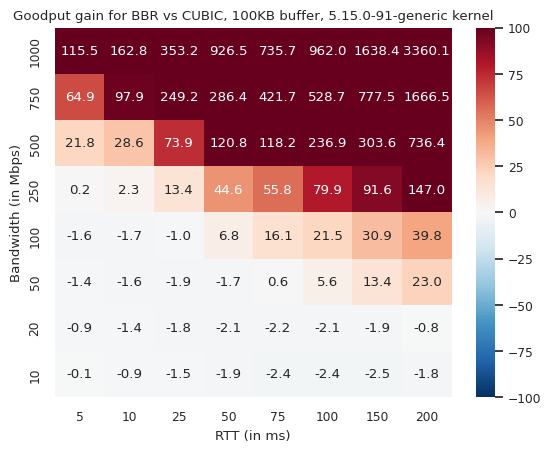

In [17]:
dat_hm = df_tput[df_tput.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="goodput_gain")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".1f", cmap="RdBu_r", center=0, vmin=-100, vmax=100)
ax.invert_yaxis()
ax.set_title("Goodput gain for " + exp_factors['cc'][1].upper() + " vs " + exp_factors['cc'][0].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("RTT (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

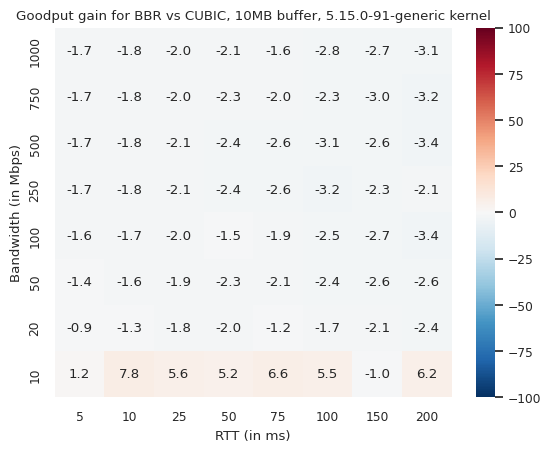

In [18]:
dat_hm = df_tput[df_tput.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="goodput_gain")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".1f", cmap="RdBu_r", center=0, vmin=-100, vmax=100)
ax.invert_yaxis()
ax.set_title("Goodput gain for " + exp_factors['cc'][1].upper() + " vs " + exp_factors['cc'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("RTT (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

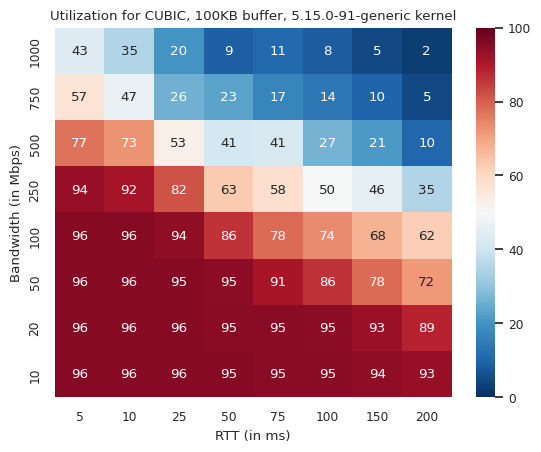

In [19]:
df_tput = pd.read_csv(StringIO(tput[0]), names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['cc'][0] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['cc'][0].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("RTT (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

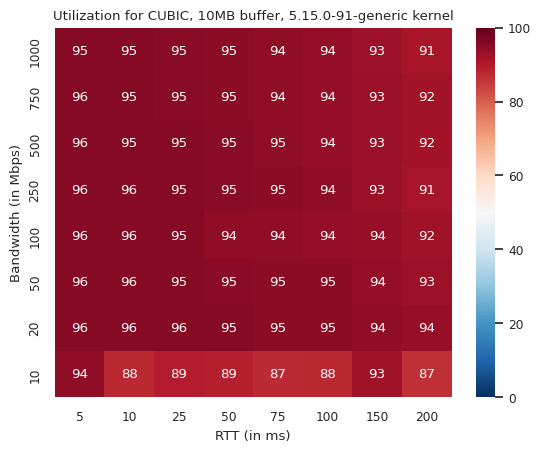

In [20]:
df_tput = pd.read_csv(StringIO(tput[0]), names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['cc'][0] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['cc'][0].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("RTT (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

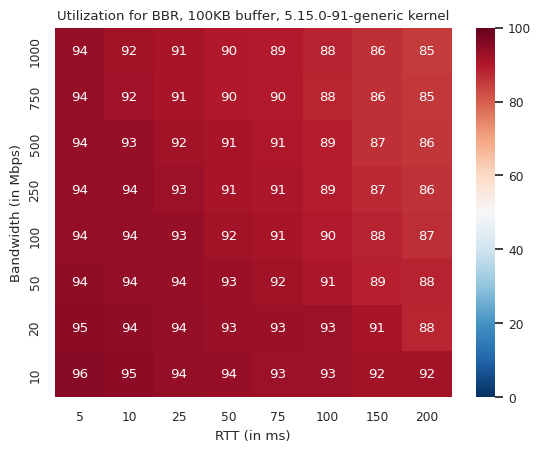

In [21]:
df_tput = pd.read_csv(StringIO(tput[0]), names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['cc'][1] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['cc'][1].upper() + ", 100KB buffer, " + kernel + " kernel")
plt.xlabel("RTT (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

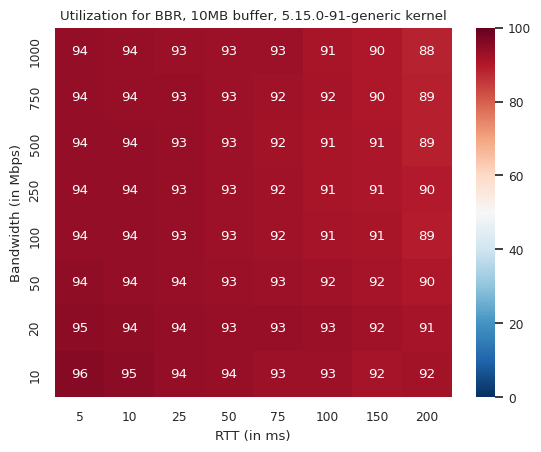

In [22]:
df_tput = pd.read_csv(StringIO(tput[0]), names = ['bufcap','bandwidth','rtt','trial','cc','goodput_'])
df_tput['goodput_'] = pd.to_numeric(df_tput['goodput_'], errors='coerce').dropna()
df_tput = df_tput.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['goodput_'], aggfunc='mean').reset_index() 
df_tput.columns = [''.join(col).strip() for col in df_tput.columns.values]
df_tput = df_tput.assign(util = 100*(df_tput['goodput_' + exp_factors['cc'][1] ]/(df_tput['bandwidth']*1000)))
dat_hm = df_tput[df_tput.bufcap==10000].pivot(index=["bandwidth"], columns=["rtt"], values="util")
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=50, vmin=0, vmax=100)
ax.invert_yaxis()
ax.set_title("Utilization for " + exp_factors['cc'][1].upper() + ", 10MB buffer, " + kernel + " kernel")
plt.xlabel("RTT (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

In [23]:
retx = tx_node.execute("cd " + data_dir + "; grep 'Kbits/sec.*sender' *.txt | awk -F'[_ .]' '{print $1\",\"$2\",\"$3\",\"$4\",\"$5\",\"$24}' ", quiet=True)

In [31]:
df_retx = pd.read_csv(StringIO(retx[0]), names = ['bufcap','bandwidth','rtt','trial','cc','retx_'])
df_retx = df_retx.fillna(0).drop(columns=['trial'])
df_retx.to_csv('data/retx_htb.csv')
df_retx.head()
df_retx = df_retx.pivot_table(columns='cc', index=['bufcap','bandwidth','rtt'], values=['retx_'], aggfunc='mean').reset_index() 
df_retx.columns = [''.join(col).strip() for col in df_retx.columns.values]

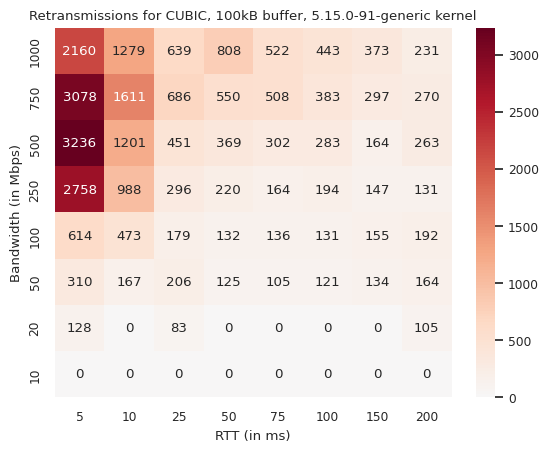

In [32]:
dat_hm = df_retx[df_retx.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="retx_"+exp_factors['cc'][0] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Retransmissions for " + exp_factors['cc'][0].upper() + ", 100kB buffer, " + kernel + " kernel")
plt.xlabel("RTT (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

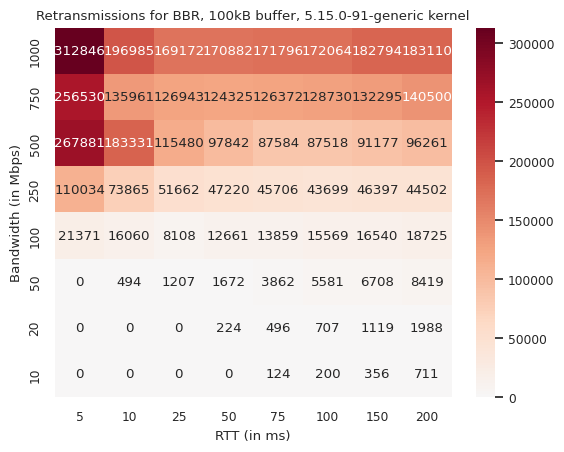

In [33]:
dat_hm = df_retx[df_retx.bufcap==100].pivot(index=["bandwidth"], columns=["rtt"], values="retx_"+exp_factors['cc'][1] )
sns.set(font_scale=0.8)
ax = sns.heatmap(dat_hm, annot=True, fmt=".0f", cmap="RdBu_r", center=0)
ax.invert_yaxis()
ax.set_title("Retransmissions for " + exp_factors['cc'][1].upper() + ", 100kB buffer, " + kernel + " kernel")
plt.xlabel("RTT (in ms)")
plt.ylabel("Bandwidth (in Mbps)")
plt.show()

100kB, 750Mbps, 10ms

In [44]:
import os
slice.get_node("h1").download_file(os.path.join(os.getcwd() + "/sender-ss_1.csv"), "sender-ss.csv")

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("sender-ss_1.csv", names=['time', 'sender', 'retx_unacked', 'retx_cum', 'cwnd', 'ssthresh', 'rtt'])
df.head()

,time,sender,retx_unacked,retx_cum,cwnd,ssthresh,rtt
0,1.720409e+09,10.10.1.1:42442,NaN,NaN,10,37,10.339
1,1.720409e+09,10.10.1.1:42442,NaN,NaN,10,41,10.315
2,1.720409e+09,10.10.1.1:42442,NaN,NaN,10,41,10.315
3,1.720409e+09,10.10.1.1:42442,NaN,NaN,10,41,10.315
4,1.720409e+09,10.10.1.1:42454,NaN,NaN,10,37,10.180


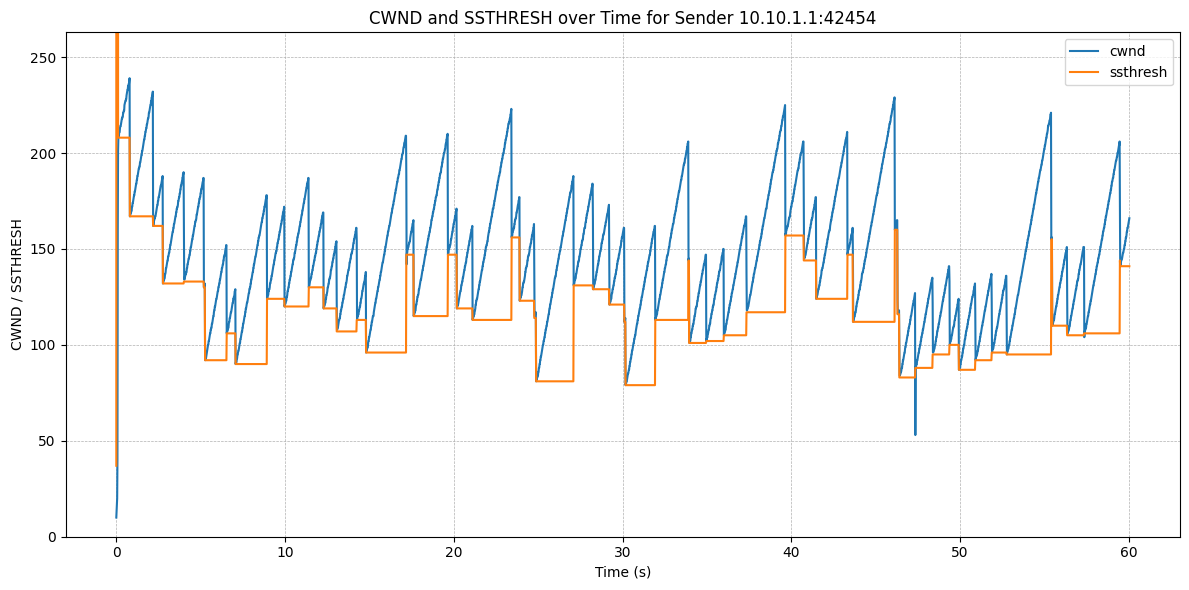

In [46]:
# Read data
df = pd.read_csv("sender-ss_1.csv", names=['time', 'sender', 'retx_unacked', 'retx_cum', 'cwnd', 'ssthresh', 'rtt'])
df['time'] = pd.to_numeric(df['time'], errors='coerce')
# df = df.dropna()
# Exclude "control" flow and keep senders with more than 100 data points
df_filtered = df[df.groupby("sender")['sender'].transform('size') > 100]

# Assuming the sender of interest is the one with the most data points
sender_of_interest = df_filtered['sender'].value_counts().idxmax()

# Filter data for the selected sender
df_single_sender = df_filtered[df_filtered['sender'] == sender_of_interest]

# Prepare plot data
time_min = df_single_sender['time'].min()
cwnd_max = 1.1 * df_single_sender['cwnd'].max()
# df_single_sender[df_single_sender['time'] == "1719781696.2039701719781696.203930"]

# Create a single plot for the sender of interest
plt.figure(figsize=(12, 6))
plt.plot(df_single_sender['time'] - time_min, df_single_sender['cwnd'], label="cwnd")
plt.plot(df_single_sender['time'] - time_min, df_single_sender['ssthresh'], label="ssthresh")
plt.ylim([0, cwnd_max])
plt.xlabel("Time (s)")
plt.ylabel("CWND / SSTHRESH")
plt.title(f"CWND and SSTHRESH over Time for Sender {sender_of_interest}")
plt.legend()

# Add grid to the plot
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

# Save the figure
plt.savefig("sender-ss.png")
plt.show()


In [61]:
import os
slice.get_node("tbf").download_file(os.path.join(os.getcwd() + "/backlog_log_1.txt"), "backlog_log.txt")
slice.get_node("tbf").download_file(os.path.join(os.getcwd() + "/dropped_1.txt"), "Dropped.txt")

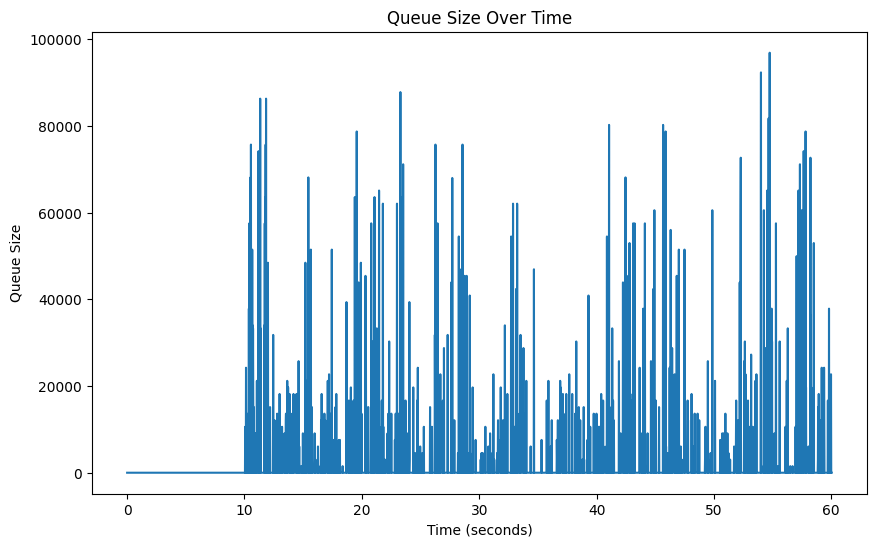

In [66]:
df_qSize = pd.read_csv('backlog_log_1.txt', sep=r'\s+', header=None, names=['time', 'queue_size_bytes', 'queue_size_packets']).reset_index()
df_qSize.drop(columns=['index'],inplace=True)
df_qSize['queue_size_bytes'] = df_qSize.loc[:,'queue_size_bytes'].str.replace('b','').str.replace('K','000').astype(int)
df_qSize['queue_size_packets'] = df_qSize.loc[:,'queue_size_packets'].str.replace('p','').astype(int)
df_qSize['time'] = pd.to_numeric(df['time'], errors='coerce')
# time_min = df_qSize['time'].min()
df_qSize = df_qSize[df_qSize['time']>=time_min]
df_qSize = df_qSize[df_qSize['time']<= df_single_sender['time'].max()]
df_qSize['time'] = df_qSize.loc[:,'time'].apply(lambda x: (x - time_min))
df_qSize.set_index('time', inplace=True)

df_qSize.drop(columns=['queue_size_packets'], inplace=True)
# threshold = 10000  # Define your threshold
# window_size = 5  # Number of entries in the window
# df_qSize = df_qSize['queue_size_bytes'].rolling(window=window_size).mean().dropna()# df_qSize = df_qSize[df_qSize['queue_size_bytes']>=40000]
# df_qSize.scatter()
plt.figure(figsize=(10, 6))
plt.plot(df_qSize.index, df_qSize['queue_size_bytes'])
plt.xlabel('Time (seconds)')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Time')
plt.savefig('qsizeOverTime.png')
plt.show()

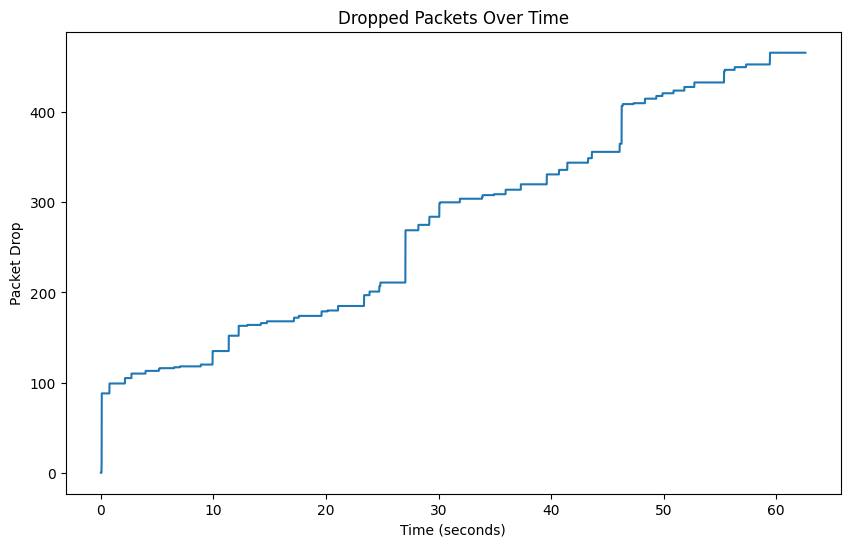

In [67]:
df_qDrop = pd.read_csv('dropped_1.txt', sep=r'\s+', header=None, names=['time', 'dropped']).reset_index()
df_qDrop.drop(columns=['index'], inplace=True)
df_qSize['time'] = pd.to_numeric(df['time'], errors='coerce')

df_qDrop = df_qDrop[df_qDrop['time'] >= time_min]
df_qDrop['time'] = df_qDrop['time'].apply(lambda x: (x - time_min))  # Convert to seconds
df_qDrop.set_index('time', inplace=True)
df_qDrop['dropped'] = df_qDrop['dropped'].str.replace(',', '').astype(int)
# df_qDrop['drop_change'] = df_qDrop['dropped'].diff().fillna(0).astype(bool)
# filtered = df_qDrop[df_qDrop['drop_change']]

# plt.figure(figsize=(10, 6))
# Plot vertical lines at the points where there is a drop change
# for time in filtered.index:
#     plt.axvline(x=time, color='red', linestyle='--', label='Packet Drop')
plt.figure(figsize=(10, 6))
plt.plot(df_qDrop.index, df_qDrop['dropped'])
# df_qDrop.plot()
plt.xlabel('Time (seconds)')
plt.ylabel('Packet Drop')
plt.title('Dropped Packets Over Time')
# plt.legend()
plt.savefig('packet_drop.png')
plt.show();

In [50]:
df_qDrop.tail(1)

,dropped
time,
62.596782,466


In [75]:
df_single_sender['ssthresh_change'] = df_single_sender['ssthresh'].diff().fillna(0).astype(bool)
ssthresh_change_times = df_single_sender[df_single_sender['ssthresh_change']]['time']

def get_data_around_time(time, df, window_size=5):
    start_time = time - window_size*(10**(-3))
    end_time = time + window_size*(10**(-3))
    return df[(df['time'] >= start_time) & (df['time'] <= end_time)]

# Collect all windows of data points around each ssthresh change time
windows = []
for change_time in ssthresh_change_times:
    window = get_data_around_time(change_time-time_min, df_qSize.reset_index(), window_size=5)
    windows.append(window)

# Combine all windows into a single DataFrame
result_df = pd.concat(windows)

# Display the result
print(result_df)

           time  queue_size_packets
0      0.000000                   0
1      0.017818                   0
2      0.035468                   0
3      0.054286                   0
0      0.000000                   0
...         ...                 ...
3281  59.630707                   0
3282  59.649981                   0
3283  59.667955                   0
3284  59.687391                   7
3285  59.705570                   0

[274 rows x 2 columns]


100kB, 100Mbps, 10ms

In [70]:
import os
slice.get_node("h1").download_file(os.path.join(os.getcwd() + "/sender-ss_2.csv"), "sender-ss.csv")

In [71]:
df = pd.read_csv("sender-ss_2.csv", names=['time', 'sender', 'retx_unacked', 'retx_cum', 'cwnd', 'ssthresh', 'rtt'])
df.head()

,time,sender,retx_unacked,retx_cum,cwnd,ssthresh,rtt
0,1.720413e+09,10.10.1.1:45374,NaN,NaN,10,37,10.256
1,1.720413e+09,10.10.1.1:45374,NaN,NaN,10,41,10.244
2,1.720413e+09,10.10.1.1:45374,NaN,NaN,10,41,10.244
3,1.720413e+09,10.10.1.1:45374,NaN,NaN,10,41,10.244
4,1.720413e+09,10.10.1.1:45374,NaN,NaN,10,181,15.536


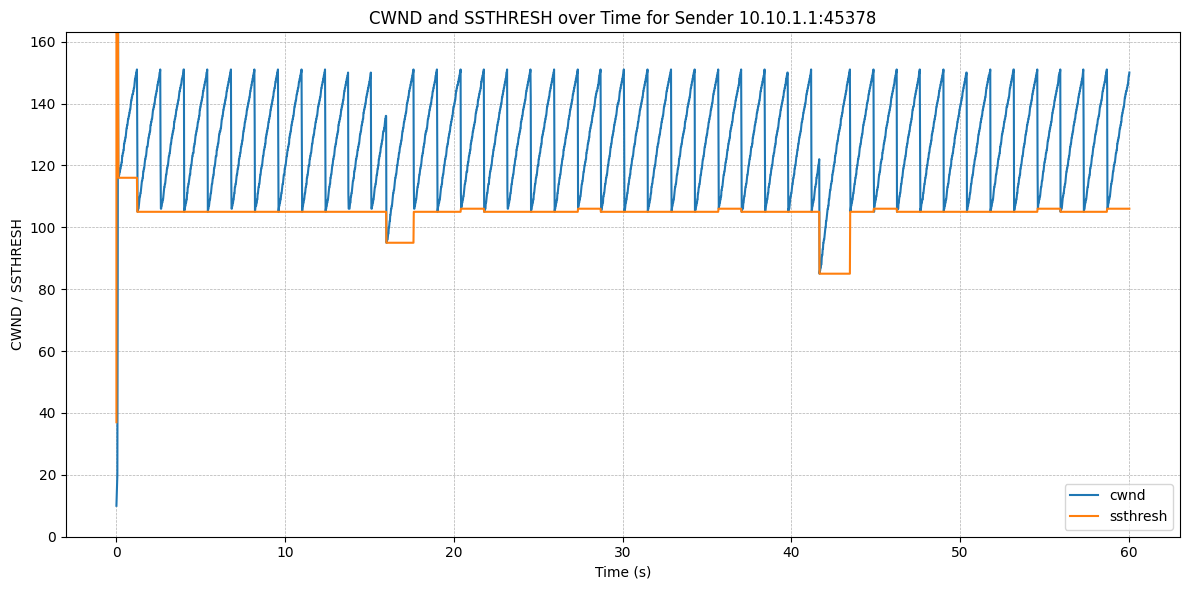

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Read data
df = pd.read_csv("sender-ss_2.csv", names=['time', 'sender', 'retx_unacked', 'retx_cum', 'cwnd', 'ssthresh', 'rtt'])
df['time'] = pd.to_numeric(df['time'], errors='coerce')
# df = df.dropna()
# Exclude "control" flow and keep senders with more than 100 data points
df_filtered = df[df.groupby("sender")['sender'].transform('size') > 100]

# Assuming the sender of interest is the one with the most data points
sender_of_interest = df_filtered['sender'].value_counts().idxmax()

# Filter data for the selected sender
df_single_sender = df_filtered[df_filtered['sender'] == sender_of_interest]

# Prepare plot data
time_min = df_single_sender['time'].min()
cwnd_max = df_single_sender['cwnd'].max()

# df_single_sender[df_single_sender['time'] == "1719781696.2039701719781696.203930"]

# Create a single plot for the sender of interest
plt.figure(figsize=(12, 6))
plt.plot(df_single_sender['time'] - time_min, df_single_sender['cwnd'], label="cwnd")
plt.plot(df_single_sender['time'] - time_min, df_single_sender['ssthresh'], label="ssthresh")
plt.ylim([0, cwnd_max])
plt.xlabel("Time (s)")
plt.ylabel("CWND / SSTHRESH")
plt.title(f"CWND and SSTHRESH over Time for Sender {sender_of_interest}")
plt.legend()

# Add grid to the plot
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()

# Save the figure
plt.savefig("sender-ss.png")
plt.show()


In [73]:
import os
slice.get_node("tbf").download_file(os.path.join(os.getcwd() + "/backlog_log_2.txt"), "backlog_log.txt")
slice.get_node("tbf").download_file(os.path.join(os.getcwd() + "/dropped_2.txt"), "Dropped.txt")

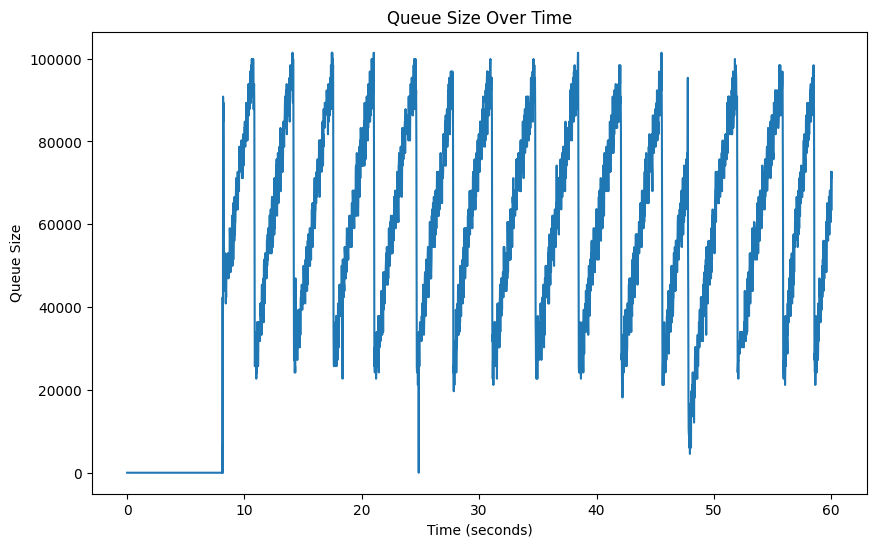

In [74]:
df_qSize = pd.read_csv('backlog_log_2.txt', sep=r'\s+', header=None, names=['time', 'queue_size_bytes', 'queue_size_packets']).reset_index()
df_qSize.drop(columns=['index'],inplace=True)
df_qSize['queue_size_bytes'] = df_qSize.loc[:,'queue_size_bytes'].str.replace('b','').str.replace('K','000').astype(int)
df_qSize['queue_size_packets'] = df_qSize.loc[:,'queue_size_packets'].str.replace('p','').astype(int)
df_qSize['time'] = pd.to_numeric(df['time'], errors='coerce')
# time_min = df_qSize['time'].min()
df_qSize = df_qSize[df_qSize['time']>=time_min]
df_qSize = df_qSize[df_qSize['time']<= df_single_sender['time'].max()]
df_qSize['time'] = df_qSize.loc[:,'time'].apply(lambda x: (x - time_min))
df_qSize.set_index('time', inplace=True)

df_qSize.drop(columns=['queue_size_packets'], inplace=True)
# threshold = 10000  # Define your threshold
# window_size = 5  # Number of entries in the window
# df_qSize = df_qSize['queue_size_bytes'].rolling(window=window_size).mean().dropna()# df_qSize = df_qSize[df_qSize['queue_size_bytes']>=40000]
# df_qSize.scatter()
plt.figure(figsize=(10, 6))
plt.plot(df_qSize.index, df_qSize['queue_size_bytes'])
plt.xlabel('Time (seconds)')
plt.ylabel('Queue Size')
plt.title('Queue Size Over Time')
plt.savefig('qsizeOverTime.png')
plt.show()

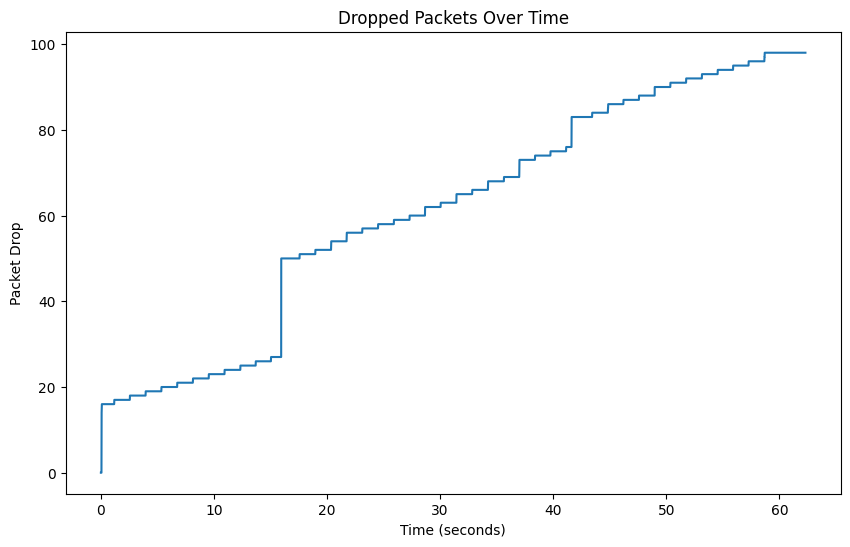

In [76]:
df_qDrop = pd.read_csv('dropped_2.txt', sep=r'\s+', header=None, names=['time', 'dropped']).reset_index()
df_qDrop.drop(columns=['index'], inplace=True)
df_qSize['time'] = pd.to_numeric(df['time'], errors='coerce')

df_qDrop = df_qDrop[df_qDrop['time'] >= time_min]
df_qDrop['time'] = df_qDrop['time'].apply(lambda x: (x - time_min))  # Convert to seconds
df_qDrop.set_index('time', inplace=True)
df_qDrop['dropped'] = df_qDrop['dropped'].str.replace(',', '').astype(int)
# df_qDrop['drop_change'] = df_qDrop['dropped'].diff().fillna(0).astype(bool)
# filtered = df_qDrop[df_qDrop['drop_change']]

# plt.figure(figsize=(10, 6))
# Plot vertical lines at the points where there is a drop change
# for time in filtered.index:
#     plt.axvline(x=time, color='red', linestyle='--', label='Packet Drop')
plt.figure(figsize=(10, 6))
plt.plot(df_qDrop.index, df_qDrop['dropped'])
# df_qDrop.plot()
plt.xlabel('Time (seconds)')
plt.ylabel('Packet Drop')
plt.title('Dropped Packets Over Time')
# plt.legend()
plt.savefig('packet_drop.png')
plt.show();

In [85]:
df_single_sender['ssthresh_change'] = df_single_sender['ssthresh'].diff().fillna(0).astype(bool)
ssthresh_change_times = df_single_sender[df_single_sender['ssthresh_change']]['time']
df_qSize = df_qSize.drop(columns=['time'])
def get_data_around_time(time, df, window_size=5):
    start_time = time - window_size*(10**(-3))
    end_time = time + window_size*(10**(-3))
    return df[(df['time'] >= start_time) & (df['time'] <= end_time)]

# Collect all windows of data points around each ssthresh change time
windows = []
for change_time in ssthresh_change_times:
    window = get_data_around_time(change_time-time_min, df_qSize.reset_index(), window_size=5)
    windows.append(window)

# Combine all windows into a single DataFrame
result_df = pd.concat(windows)

# Display the result
print(result_df)

           time  queue_size_bytes
1      0.017395                 0
2      0.038816                 0
3      0.056424                 0
4      0.079441                 0
68     1.255402                 0
125    2.295467                 0
212    3.896094                 0
235    4.351891                 0
335    6.213212             62074
409    7.632529             83270
557   10.402907             74186
713   13.231616             78728
929   17.196172             49962
952   17.604958             51476
1061  19.589471             96896
1739  31.907582             86298
1827  33.435661             49962
1880  34.370598             66616
1971  35.993141             86298
2121  38.769288             81756
2199  40.209227             43906
2278  41.587150             66616
2354  42.954871             96896
2435  44.413892             51476
2511  45.797906             77214
2590  47.222306             36336
2689  49.089877             27252
2794  50.944530             74186
3221  58.90547

### Transfer experiment data

In [ ]:
tx_node.execute('tar -czf ' + data_dir + '.tgz ' + data_dir)

In [ ]:
tx_node.download_file(data_dir + '.tgz', '/home/ubuntu/' + data_dir + '.tgz')

### Delete your slice

When you finish your experiment, you should delete your slice! The following cells deletes all the resources in your slice, freeing them for other experimenters.

In [4]:
slice = fablib.get_slice(name=slice_name)
fablib.delete_slice(slice_name)

In [5]:
# slice should end up in "Dead" state
# re-run this cell until you see it in "Dead" state
slice.update()
_ = slice.show()

ID,6769290e-74c3-4095-8e17-90e12587ffb1
Name,re-when-to-use-bbr-nm3833_0000195331
Lease Expiration (UTC),2024-07-10 18:28:19 +0000
Lease Start (UTC),2024-07-03 18:21:32 +0000
Project ID,073ee843-2310-45bd-a01f-a15d808827dc
State,StableOK
